# <center>Ishaan Chawathe</center>
# <center> Modeling Cluster 2 </center>

In [41]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif

RANDOM_STATE = 32
import warnings
warnings.filterwarnings('ignore')

In [136]:
!pip install xgboost

## Section 3.3(step 2)

In [43]:
# Loading the pre-processed data
df = pd.read_csv("train_data_Processed.csv")
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,Bankrupt,cluster_id_pred
0,-4.328723,-2.949938,-0.922311,1.347478,-1.875776,3.104547,-0.037355,-0.808933,1.108289,-0.216169,...,-0.567413,-0.585520,1.535418,0.053807,0.107681,0.011554,1.276770,0.275025,0,4
1,1.094151,1.472453,0.132183,-0.300871,-0.504754,-1.832859,-0.031414,-1.170645,0.008114,-0.556370,...,-1.075769,-0.945268,-0.668545,-1.454529,-1.121609,0.843183,-0.421891,-0.419246,0,2
2,4.088633,1.259710,-1.776226,1.050030,1.501352,-0.340699,0.833061,-2.429603,-0.968284,0.329488,...,0.710081,-0.577257,-0.530180,-0.899643,-0.333037,-1.430197,0.090152,-0.655980,0,2
3,-3.933860,6.750754,2.322990,-4.176331,2.404033,3.765933,0.485070,0.206727,-1.427313,-1.984952,...,-1.761042,1.424276,1.402486,0.986018,1.197131,0.408706,0.192866,-0.402362,0,3
4,-0.695598,2.372324,3.048846,0.490309,-3.344630,0.242807,0.115051,0.733233,2.672528,2.512248,...,-0.304360,-0.521027,-1.303879,0.050446,1.210307,0.004957,-0.065199,1.614544,0,3


In [45]:

# Cluster summary: count and bankruptcy rate
cluster_summary = df.groupby("cluster_id_pred")["Bankrupt"].agg(["count", "sum"])
cluster_summary["Bankrupt_Rate"] = cluster_summary["sum"] / cluster_summary["count"]
cluster_summary

,count,sum,Bankrupt_Rate
cluster_id_pred,,,
1,1148,41,0.035714
2,1547,3,0.001939
3,1005,11,0.010945
4,1135,143,0.125991
5,972,0,0.000000


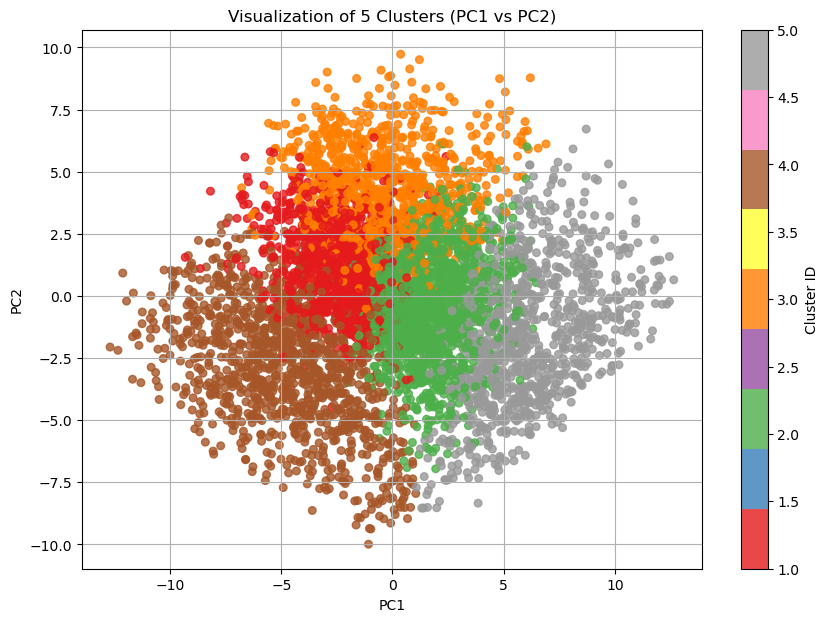

In [55]:
import matplotlib.pyplot as plt

# Assuming 'processed_train' has PC1, PC2, ..., PC26 and 'cluster_id_pred'
# Plot using PC1 vs PC2 (most common visualization)

plt.figure(figsize=(10, 7))

# Scatter plot with colors for each cluster
scatter = plt.scatter(
    df['PC1'], 
    df['PC2'], 
    c=df['cluster_id_pred'], 
    cmap='Set1', 
    s=30, 
    alpha=0.8
)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualization of 5 Clusters (PC1 vs PC2)')
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True)
plt.show()


### Separating subgroups

In [9]:
X_cluster_1 = df[df['cluster_id_pred'] == 1].drop([ 'cluster_id_pred', 'Bankrupt'], axis=1)
y_cluster_1 = df[df['cluster_id_pred'] == 1]['Bankrupt']

X_cluster_2 = df[df['cluster_id_pred'] == 2].drop([ 'cluster_id_pred', 'Bankrupt'], axis=1)
y_cluster_2 = df[df['cluster_id_pred'] == 2]['Bankrupt']

X_cluster_3 = df[df['cluster_id_pred'] == 3].drop(['cluster_id_pred', 'Bankrupt'], axis=1)
y_cluster_3 = df[df['cluster_id_pred'] == 3]['Bankrupt']

X_cluster_4 = df[df['cluster_id_pred'] == 4].drop([ 'cluster_id_pred', 'Bankrupt'], axis=1)
y_cluster_4 = df[df['cluster_id_pred'] == 4]['Bankrupt']

X_cluster_5 = df[df['cluster_id_pred'] == 5].drop([ 'cluster_id_pred', 'Bankrupt'], axis=1)
y_cluster_5 = df[df['cluster_id_pred'] == 5]['Bankrupt']


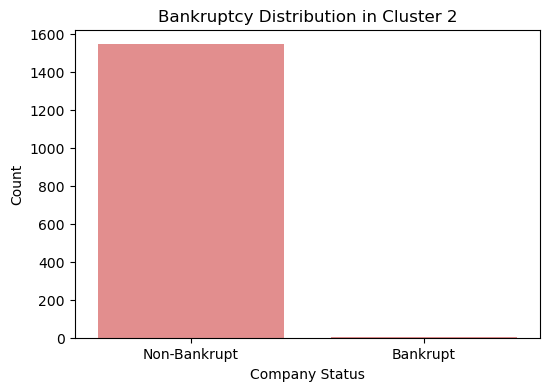

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
#Visualizing the bankruptcy distribution in cluster 2
df_cluster_2 = X_cluster_2.copy()
df_cluster_2['Bankrupt'] = y_cluster_2

plt.figure(figsize=(6,4))
sns.countplot(data=df_cluster_2, x='Bankrupt', color = 'lightcoral')
plt.title('Bankruptcy Distribution in Cluster 2')
plt.xticks([0,1], ['Non-Bankrupt', 'Bankrupt'])
plt.xlabel('Company Status')
plt.ylabel('Count')
plt.show()

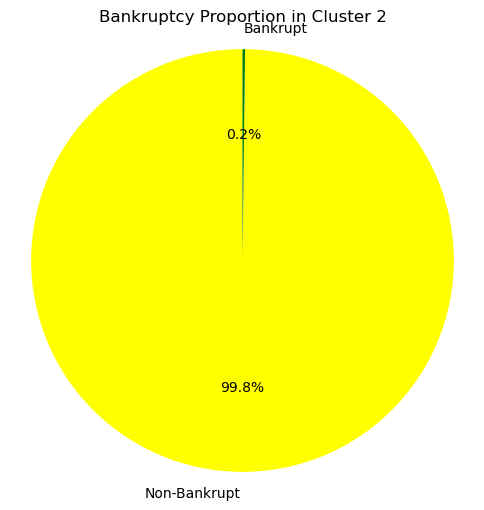

In [33]:
bankrupt_counts = df_cluster_2['Bankrupt'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(bankrupt_counts, labels=['Non-Bankrupt', 'Bankrupt'], autopct='%1.1f%%', startangle=90, colors=['yellow', 'green'])
plt.title('Bankruptcy Proportion in Cluster 2')
plt.axis('equal')
plt.show()

## Section 3.3 (step 2)

- This function is for finding the best base learners

In [148]:
def find_best_base_learners(X, y, RANDOM_STATE=32):
    result = {}
    # Base learners
    base_learners = [
        # Use different types of Logistic regression
        ('Logistic Regression', LogisticRegression(random_state=RANDOM_STATE, solver='liblinear',class_weight='balanced')),
        ('Random Forest', RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100)),
        ('SVC', SVC(random_state=RANDOM_STATE, C=1, class_weight='balanced',kernel='rbf')),
        ('KNN', KNeighborsClassifier()),
        ('Decision Tree', DecisionTreeClassifier(random_state=RANDOM_STATE)),
        ('XGBoost', XGBClassifier(random_state=RANDOM_STATE, n_estimators=100, max_depth=5)),
        ('AdaBoost', AdaBoostClassifier(random_state=RANDOM_STATE)),
        ('Bagging', BaggingClassifier(random_state=RANDOM_STATE))
    ]

    # Train each base learner
    for learner_name, learner in base_learners:
        
        learner.fit(X, y);
        y_pred = learner.predict(X);
        # Find confusion matrix
        cm = confusion_matrix(y, y_pred);
        # print(f"Confusion matrix for {learner_name}:\n{cm}")
        # print("TT/(TT+TF) = ", cm[1][1]/(cm[1][0]+cm[1][1]))
        # print("---------------------------")
        result[learner_name] = (cm, cm[1][1]/(cm[1][0]+cm[1][1])) 
    return result


## Cluster 2

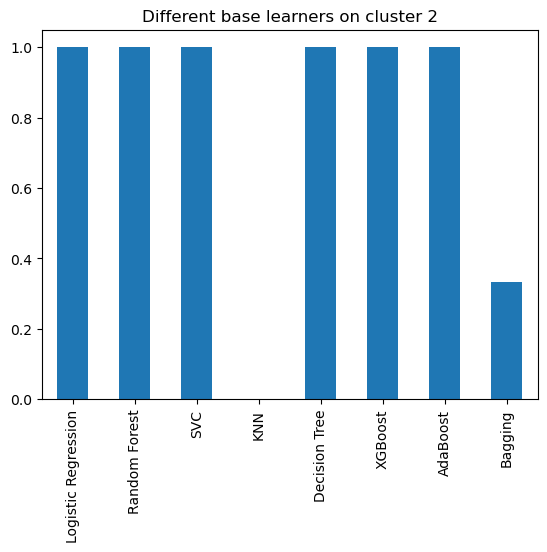

In [151]:
cluster_2_results = find_best_base_learners(X_cluster_2, y_cluster_2)
df_cluster_2 = pd.DataFrame(cluster_2_results).T
df_cluster_2.columns = ['Confusion Matrix', 'Recall']
# sort based on recall
df_cluster_2.sort_values(by='Recall', ascending=False)
df_cluster_2['Recall'].plot(kind='bar', title='Different base learners on cluster 2');


- Here we are reporting the confusion matrix and accuracy for each base learners

In [198]:
from sklearn.model_selection import cross_val_score
base_models = {
    "rf":RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100, max_depth=7, class_weight='balanced'),
    "SVC": SVC(random_state=RANDOM_STATE, C=1, class_weight='balanced', kernel='rbf'),
    "KNN": KNeighborsClassifier(n_neighbors=5)
    
    
}

result = {}

for learner_name, learner in base_models.items():
    learner.fit(X_cluster_2, y_cluster_2)
    y_pred = learner.predict(X_cluster_2)
    cm = confusion_matrix(y_cluster_2, y_pred)

    if cm.shape == (2, 2):
        TT = cm[1][1]
        TF = cm[1][0]
        acc_tt_tf = TT / (TT + TF) if (TT + TF) > 0 else 0
    else:
        TT = TF = acc_tt_tf = 0

    result[learner_name] = {
        "confusion_matrix": cm,
        "TT/(TT+TF)": round(acc_tt_tf, 3)
    }

# Print all results
for learner_name, metrics in result.items():
    print(f"{learner_name}")
    print(f"  Confusion Matrix:\n{metrics['confusion_matrix']}")
    print(f"  accuracy: {metrics['TT/(TT+TF)']}\n")

rf
  Confusion Matrix:
[[1544    0]
 [   0    3]]
  accuracy: 1.0

Decision Tree
  Confusion Matrix:
[[1544    0]
 [   0    3]]
  accuracy: 1.0

SVC
  Confusion Matrix:
[[1544    0]
 [   0    3]]
  accuracy: 1.0

KNN
  Confusion Matrix:
[[1544    0]
 [   3    0]]
  accuracy: 0.0



- Here we are building the meta learner with stacking method and reporting the confusion matrix and the accuracy

In [200]:
k_features = 20
selector = SelectKBest(score_func=mutual_info_classif, k=k_features)
X_cluster_2_selected = selector.fit_transform(X_cluster_2, y_cluster_2)

base_models = [
    ("rf", RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100, max_depth=5, class_weight='balanced')),
    ("SVC", SVC(random_state=RANDOM_STATE, C=0.01, class_weight='balanced', degree=2 ,kernel='sigmoid')),
    ("KNN", KNeighborsClassifier())
]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

#meta_model=XGBClassifier(random_state=RANDOM_STATE, n_estimators=100, max_depth=5, scale_pos_weight=10)
meta_model = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced')
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=skf)
#y_pred_stack = cross_val_predict(stacking_model, X_cluster_2_selected, y_cluster_2, cv=skf)

y_pred_proba_stack = cross_val_predict(stacking_model, X_cluster_2_selected, y_cluster_2, cv=skf, method='predict_proba')[:, 1]

threshold = 0.75  
y_pred_stack = (y_pred_proba_stack > threshold).astype(int)

# Confusion Matrix and Evaluation
cm = confusion_matrix(y_cluster_2, y_pred_stack)
TT = cm[1][1]
TF = cm[1][0]
acc = TT / (TT + TF) if (TT + TF) > 0 else 0

print(f"Accuracy (TT / (TT + TF)): {acc:.3f}")
print(f"Confusion Matrix :\n{cm}")
print(f"Number of Features Used: {X_cluster_2_selected.shape[1]}")
print(f"Number of bankrupt companies in cluster 2: {int(y_cluster_2.sum())}")
print(f"Total samples in cluster 2: {len(y_cluster_2)}")

Accuracy (TT / (TT + TF)): 1.000
Confusion Matrix :
[[1466   78]
 [   0    3]]
Number of Features Used: 20
Number of bankrupt companies in cluster 2: 3
Total samples in cluster 2: 1547


### Saving the Stacking model and selector to file to use it in the the next steps

In [159]:
import joblib

stacking_model.fit(X_cluster_2_selected, y_cluster_2)

joblib.dump(selector, "cluster2_selector.pkl")
joblib.dump(stacking_model, "cluster2_model.pkl")
joblib.dump(X_cluster_2.columns.tolist(), "cluster2_feature_names.pkl")

print("Selector and model saved.")


Selector and model saved.
